*Accompanying code examples of the book "Introduction to Artificial Neural Networks and Deep Learning: A Practical Guide with Applications in Python" by [Sebastian Raschka](https://sebastianraschka.com). All code examples are released under the [MIT license](https://github.com/rasbt/deep-learning-book/blob/master/LICENSE). If you find this content useful, please consider supporting the work by buying a [copy of the book](https://leanpub.com/ann-and-deeplearning).*
  
Other code examples and content are available on [GitHub](https://github.com/rasbt/deep-learning-book). The PDF and ebook versions of the book are available through [Leanpub](https://leanpub.com/ann-and-deeplearning).

In [1]:
%load_ext watermark
%watermark -a 'Sebastian Raschka' -v -p torch

Sebastian Raschka 

CPython 3.7.1
IPython 7.2.0

torch 1.0.0


- Runs on CPU or GPU (if available)

# Model Zoo -- Convolutional Conditional Variational Autoencoder 

## (with labels in reconstruction loss)

A simple convolutional conditional variational autoencoder that compresses 768-pixel MNIST images down to a 50-pixel latent vector representation.

This implementation concatenates the inputs with the class labels when computing the reconstruction loss as it is commonly done in non-convolutional conditional variational autoencoders. This leads to substantially poorer results compared to the implementation that does NOT concatenate the labels with the inputs to compute the reconstruction loss. For reference, see the implementation [./autoencoder-cnn-cvae_no-out-concat.ipynb](./autoencoder-cnn-cvae_no-out-concat.ipynb)

## Imports

In [2]:
import numpy as np
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision import transforms

In [3]:
##########################
### SETTINGS
##########################

# Device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('Device:', device)

# Hyperparameters
random_seed = 0
learning_rate = 0.001
num_epochs = 50
batch_size = 128

# Architecture
num_classes = 10
num_features = 784
num_latent = 50


##########################
### MNIST DATASET
##########################

# Note transforms.ToTensor() scales input images
# to 0-1 range
train_dataset = datasets.MNIST(root='data', 
                               train=True, 
                               transform=transforms.ToTensor(),
                               download=True)

test_dataset = datasets.MNIST(root='data', 
                              train=False, 
                              transform=transforms.ToTensor())


train_loader = DataLoader(dataset=train_dataset, 
                          batch_size=batch_size, 
                          shuffle=True)

test_loader = DataLoader(dataset=test_dataset, 
                         batch_size=batch_size, 
                         shuffle=False)

# Checking the dataset
for images, labels in train_loader:  
    print('Image batch dimensions:', images.shape)
    print('Image label dimensions:', labels.shape)
    break

Device: cuda:0
Image batch dimensions: torch.Size([128, 1, 28, 28])
Image label dimensions: torch.Size([128])


## Model

In [4]:
##########################
### MODEL
##########################


def to_onehot(labels, num_classes, device):

    labels_onehot = torch.zeros(labels.size()[0], num_classes).to(device)
    labels_onehot.scatter_(1, labels.view(-1, 1), 1)

    return labels_onehot


class ConditionalVariationalAutoencoder(torch.nn.Module):

    def __init__(self, num_features, num_latent, num_classes):
        super(ConditionalVariationalAutoencoder, self).__init__()
        
        self.num_classes = num_classes
        
        
        ###############
        # ENCODER
        ##############
        
        # calculate same padding:
        # (w - k + 2*p)/s + 1 = o
        # => p = (s(o-1) - w + k)/2

        self.enc_conv_1 = torch.nn.Conv2d(in_channels=1+self.num_classes,
                                          out_channels=16,
                                          kernel_size=(6, 6),
                                          stride=(2, 2),
                                          padding=0)

        self.enc_conv_2 = torch.nn.Conv2d(in_channels=16,
                                          out_channels=32,
                                          kernel_size=(4, 4),
                                          stride=(2, 2),
                                          padding=0)                 
        
        self.enc_conv_3 = torch.nn.Conv2d(in_channels=32,
                                          out_channels=64,
                                          kernel_size=(2, 2),
                                          stride=(2, 2),
                                          padding=0)                     
        
        self.z_mean = torch.nn.Linear(64*2*2, num_latent)
        # in the original paper (Kingma & Welling 2015, we use
        # have a z_mean and z_var, but the problem is that
        # the z_var can be negative, which would cause issues
        # in the log later. Hence we assume that latent vector
        # has a z_mean and z_log_var component, and when we need
        # the regular variance or std_dev, we simply use 
        # an exponential function
        self.z_log_var = torch.nn.Linear(64*2*2, num_latent)
        
        
        
        ###############
        # DECODER
        ##############
        
        self.dec_linear_1 = torch.nn.Linear(num_latent+self.num_classes, 64*2*2)
               
        self.dec_deconv_1 = torch.nn.ConvTranspose2d(in_channels=64,
                                                     out_channels=32,
                                                     kernel_size=(2, 2),
                                                     stride=(2, 2),
                                                     padding=0)
                                 
        self.dec_deconv_2 = torch.nn.ConvTranspose2d(in_channels=32,
                                                     out_channels=16,
                                                     kernel_size=(4, 4),
                                                     stride=(3, 3),
                                                     padding=1)
        
        self.dec_deconv_3 = torch.nn.ConvTranspose2d(in_channels=16,
                                                     out_channels=11,
                                                     kernel_size=(6, 6),
                                                     stride=(3, 3),
                                                     padding=4)        


    def reparameterize(self, z_mu, z_log_var):
        # Sample epsilon from standard normal distribution
        eps = torch.randn(z_mu.size(0), z_mu.size(1)).to(device)
        # note that log(x^2) = 2*log(x); hence divide by 2 to get std_dev
        # i.e., std_dev = exp(log(std_dev^2)/2) = exp(log(var)/2)
        z = z_mu + eps * torch.exp(z_log_var/2.) 
        return z
        
    def encoder(self, features, targets):
        
        ### Add condition
        onehot_targets = to_onehot(targets, self.num_classes, device)
        onehot_targets = onehot_targets.view(-1, self.num_classes, 1, 1)
        
        ones = torch.ones(features.size()[0], 
                          self.num_classes,
                          features.size()[2], 
                          features.size()[3], 
                          dtype=features.dtype).to(device)
        ones = ones * onehot_targets
        x = torch.cat((features, ones), dim=1)
        
        x = self.enc_conv_1(x)
        x = F.leaky_relu(x)
        #print('conv1 out:', x.size())
        
        x = self.enc_conv_2(x)
        x = F.leaky_relu(x)
        #print('conv2 out:', x.size())
        
        x = self.enc_conv_3(x)
        x = F.leaky_relu(x)
        #print('conv3 out:', x.size())
        
        z_mean = self.z_mean(x.view(-1, 64*2*2))
        z_log_var = self.z_log_var(x.view(-1, 64*2*2))
        encoded = self.reparameterize(z_mean, z_log_var)
        return z_mean, z_log_var, encoded
    
    def decoder(self, encoded, targets):
        ### Add condition
        onehot_targets = to_onehot(targets, self.num_classes, device)
        encoded = torch.cat((encoded, onehot_targets), dim=1)        
        
        x = self.dec_linear_1(encoded)
        x = x.view(-1, 64, 2, 2)
        
        x = self.dec_deconv_1(x)
        x = F.leaky_relu(x)
        #print('deconv1 out:', x.size())
        
        x = self.dec_deconv_2(x)
        x = F.leaky_relu(x)
        #print('deconv2 out:', x.size())
        
        x = self.dec_deconv_3(x)
        x = F.leaky_relu(x)
        #print('deconv1 out:', x.size())
        
        decoded = torch.sigmoid(x)
        return decoded

    def forward(self, features, targets):
        
        z_mean, z_log_var, encoded = self.encoder(features, targets)
        decoded = self.decoder(encoded, targets)
        
        return z_mean, z_log_var, encoded, decoded

    
torch.manual_seed(random_seed)
model = ConditionalVariationalAutoencoder(num_features,
                                          num_latent,
                                          num_classes)
model = model.to(device)
    

##########################
### COST AND OPTIMIZER
##########################

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)  

## Training

In [5]:
for epoch in range(num_epochs):
    for batch_idx, (features, targets) in enumerate(train_loader):
        
        features = features.to(device)
        targets = targets.to(device)

        ### FORWARD AND BACK PROP
        z_mean, z_log_var, encoded, decoded = model(features, targets)

        # cost = reconstruction loss + Kullback-Leibler divergence
        kl_divergence = (0.5 * (z_mean**2 + 
                                torch.exp(z_log_var) - z_log_var - 1)).sum()
        
        
        ### Add condition
        onehot_targets = to_onehot(targets, num_classes, device)
        onehot_targets = onehot_targets.view(-1, num_classes, 1, 1)
        
        ones = torch.ones(features.size()[0], 
                          num_classes,
                          features.size()[2], 
                          features.size()[3], 
                          dtype=features.dtype).to(device)
        ones = ones * onehot_targets
        x_con = torch.cat((features, ones), dim=1)
        
        
        ### Compute loss
        pixelwise_bce = F.binary_cross_entropy(decoded, x_con, reduction='sum')
        cost = kl_divergence + pixelwise_bce
        
        ### UPDATE MODEL PARAMETERS
        optimizer.zero_grad()
        cost.backward()
        optimizer.step()
        
        ### LOGGING
        if not batch_idx % 50:
            print ('Epoch: %03d/%03d | Batch %03d/%03d | Cost: %.4f' 
                   %(epoch+1, num_epochs, batch_idx, 
                     len(train_loader), cost))

Epoch: 001/050 | Batch 000/469 | Cost: 767976.6875
Epoch: 001/050 | Batch 050/469 | Cost: 596610.6250
Epoch: 001/050 | Batch 100/469 | Cost: 373679.2500
Epoch: 001/050 | Batch 150/469 | Cost: 369412.3125
Epoch: 001/050 | Batch 200/469 | Cost: 373000.0625
Epoch: 001/050 | Batch 250/469 | Cost: 369968.6875
Epoch: 001/050 | Batch 300/469 | Cost: 370306.9688
Epoch: 001/050 | Batch 350/469 | Cost: 368222.4375
Epoch: 001/050 | Batch 400/469 | Cost: 369047.4688
Epoch: 001/050 | Batch 450/469 | Cost: 369087.3438
Epoch: 002/050 | Batch 000/469 | Cost: 368801.5000
Epoch: 002/050 | Batch 050/469 | Cost: 367756.4062
Epoch: 002/050 | Batch 100/469 | Cost: 370259.1875
Epoch: 002/050 | Batch 150/469 | Cost: 367405.6562
Epoch: 002/050 | Batch 200/469 | Cost: 367339.2188
Epoch: 002/050 | Batch 250/469 | Cost: 366423.7188
Epoch: 002/050 | Batch 300/469 | Cost: 366465.1250
Epoch: 002/050 | Batch 350/469 | Cost: 369257.6562
Epoch: 002/050 | Batch 400/469 | Cost: 364754.9688
Epoch: 002/050 | Batch 450/469 

# Evaluation

### Reconstruction

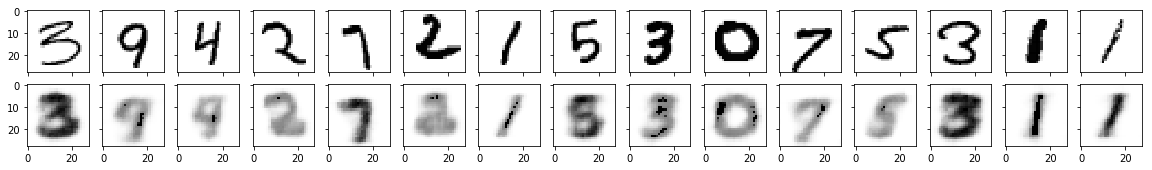

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt

##########################
### VISUALIZATION
##########################

n_images = 15
image_width = 28

fig, axes = plt.subplots(nrows=2, ncols=n_images, 
                         sharex=True, sharey=True, figsize=(20, 2.5))
orig_images = features[:n_images]
decoded_images = decoded[:n_images, 0]

for i in range(n_images):
    for ax, img in zip(axes, [orig_images, decoded_images]):
        ax[i].imshow(img[i].detach().to(torch.device('cpu')).reshape((image_width, image_width)), cmap='binary')

### New random-conditional images

Class Label 0


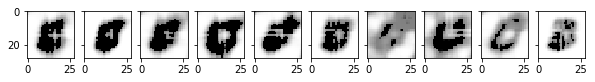

Class Label 1


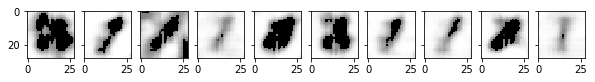

Class Label 2


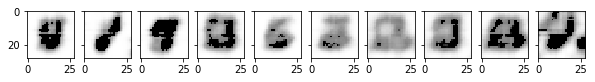

Class Label 3


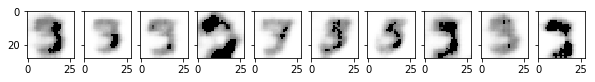

Class Label 4


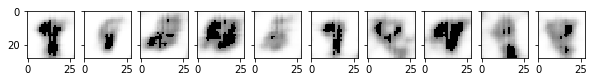

Class Label 5


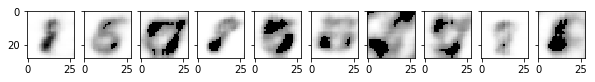

Class Label 6


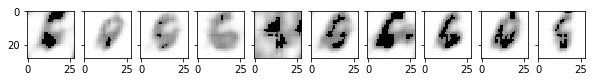

Class Label 7


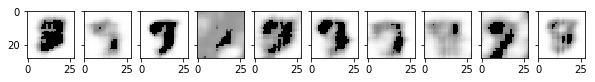

Class Label 8


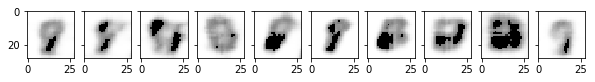

Class Label 9


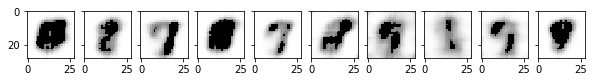

In [7]:
for i in range(10):

    ##########################
    ### RANDOM SAMPLE
    ##########################    
    
    labels = torch.tensor([i]*10).to(device)
    n_images = labels.size()[0]
    rand_features = torch.randn(n_images, num_latent).to(device)
    new_images = model.decoder(rand_features, labels)

    ##########################
    ### VISUALIZATION
    ##########################

    image_width = 28

    fig, axes = plt.subplots(nrows=1, ncols=n_images, figsize=(10, 2.5), sharey=True)
    decoded_images = new_images[:n_images, 0]

    print('Class Label %d' % i)

    for ax, img in zip(axes, decoded_images):
        ax.imshow(img.detach().to(torch.device('cpu')).reshape((image_width, image_width)), cmap='binary')
        
    plt.show()

In [8]:
%watermark -iv

numpy       1.15.4
torch       1.0.0

